In [87]:
# Wavefunction generation
from pyscf import mcscf, fci, lib 
from pyscf import gto, scf, tools, dft
import api as pyq 
import importlib
import os
import h5py
import pandas as pd
import pdb
import pyscf
import numpy as np
import pyqmc
import scipy
import matplotlib.pyplot as plt
from pyscf.scf.hf import dump_scf_summary
from concurrent.futures import ProcessPoolExecutor
from pyscf.scf.chkfile import dump_scf
print(pyq.__file__)
print(pyscf.__file__)

/Users/ksu/Documents/GitHub/pyqmc/pyqmc/api.py
/Users/ksu/Software/anaconda3/lib/python3.11/site-packages/pyscf/__init__.py


In [88]:
# H2 molecule
def run_scf(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.;H 0. 0. 1.;", basis=f'ccecpccpvdz', unit='bohr')
    mf = scf.UHF(mol)
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm)
    dump_scf(mf.mol, 'scf.hdf5', mf.energy_tot(), mf.mo_energy, mf.mo_coeff, mf.mo_occ)
    return mf

def run_lda_be(scf_checkfile):
    print("Be atom neutral LDA spin=2")
    mol = gto.M(atom="Be 0. 0. 0.", spin=2,basis=f'ccpvdz', unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")        
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_li(scf_checkfile):
    print("Li atom neutral LDA spin=1")
    mol = gto.M(atom="Li 0. 0. 0.",basis=f'ccpvtz', spin=1, unit='bohr')
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_he(scf_checkfile):
    print("He atom neutral LDA spin=0")
    # mol = gto.M(atom="He 0. 0. 0.", basis="ccECP_cc-pVDZ", ecp="ccecp", unit='bohr')
    mol = gto.M(atom="He 0. 0. 0.", basis="ccpvdz", unit='bohr')    
    print("HF")
    mf = scf.UHF(mol)
    mf.kernel()
    print("LDA")    
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf

def run_lda_h2(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.; H 0. 0. 2", spin = 2, basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.xc='LDA, VWN'
    mf.kernel()    
    # mf.kernel(dm, xc='LDA,VWN')
    return mf

def run_lda(scf_checkfile):
    mol = gto.M(atom="H 0. 0. 0.", spin=1,basis=f'ccecpccpvdz', unit='bohr')
    mf = dft.UKS(mol)
    # mf.verbose=6
    mf.chkfile = scf_checkfile
    dm = mf.init_guess_by_atom()
    mf.kernel(dm, xc='LDA')
    return mf
    
def run_casscf(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    mc = mcscf.CASSCF(mf,2,2)
    mc.chkfile = ci_checkfile
    mc.kernel()
    with h5py.File(mc.chkfile, "a") as f:
        print("Available output from CASSCF:", f["mcscf"].keys())
        f["mcscf/nelecas"] = list(mc.nelecas)
        f["mcscf/ci"] = mc.ci
    return mc

def run_casci(scf_checkfile, ci_checkfile):
    cell, mf = pyq.recover_pyscf(scf_checkfile, cancel_outputs=False)
    # ncas: orbitals
    # nelecas: electrons
    ncas = 2
    nelecas = mf.nelec
    mc = mcscf.CASCI(mf, ncas, nelecas)
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff
        print("Available output from CASCI:", f["ci"].keys())
    return mc

def make_wf_object(scf_checkfile, ci_checkfile):
    mol, mf, mc = pyq.recover_pyscf(scf_checkfile, ci_checkfile=ci_checkfile)
    wf, _ = pyq.generate_wf(mol, mf, mc=mc)
    return wf

def stat_qmc(etot, filename):
    block_sizes = np.linspace(2,len(etot[discard:])//16, 10, dtype=int)
    reblocks = [len(etot)//s for s in block_sizes]

    plt.figure()
    df = pd.DataFrame([pyq.read_mc_output(filename, warmup=discard, reblock=reblock) for reblock in reblocks])
    df['block_size'] = block_sizes
    plt.plot("block_size",'energytotal_err',data=df, marker='o')
    plt.xlabel("Block size")
    plt.ylabel("Estimated uncertainty (Ha)")

def reblock(e, discard, reblock_size):
    e = e[discard:]
    vals = pyqmc.reblock.reblock(e,int(len(e)/reblock_size))
    # import pdb
    # pdb.set_trace()
    
    e_m  = np.mean(vals, axis=0)
    e_d  = scipy.stats.sem(vals, axis=0)    
    return e, e_m, e_d

for fname in ['scf.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)    
            
scf_checkfile = "scf.hdf5"
ci_checkfile = "ci.hdf5"
# mf = run_scf(scf_checkfile)
mf_lda = run_lda_he(scf_checkfile)
# mcc = run_casci(scf_checkfile, ci_checkfile)

He atom neutral LDA spin=0
HF
converged SCF energy = -2.85516047724274  <S^2> = 0  2S+1 = 1
LDA
converged SCF energy = -2.82670655418611  <S^2> = 4.4408921e-16  2S+1 = 1


In [89]:
from recipes import ABOPTIMIZE, OPTIMIZE
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
    # Jastrow optimizationn
    
for fname in ['sj.hdf5']:
    if os.path.isfile(fname):
        os.remove(fname)
print("RUNNING VMC OPTIMIZATION")
# pyq.OPTIMIZE(scf_checkfile, "sj.hdf5", ci_checkfile=ci_checkfile, max_iterations=2, verbose=False)
recipes.OPTIMIZE(scf_checkfile, "sj.hdf5", max_iterations=4, nconfig=200, verbose=True)

# Jastrow optimization results
df = pyq.read_opt("sj.hdf5")
df

RUNNING VMC OPTIMIZATION
starting warmup
finished warmup
----------vmc done
descent en -2.8547746133357648 0.02758373349326495  estimated sigma  3.9009290007060287
descent |grad| 0.6925597028991409
----------vmc done
descent en -2.9323453259891954 0.008736981968612017  estimated sigma  1.2355958394220299
descent |grad| 0.14085518484552467
----------vmc done
descent en -2.8702891413673983 0.014307222729298458  estimated sigma  2.023346842366649
descent |grad| 0.1849876481641584
----------vmc done
descent en -2.9398715051830098 0.006320854190307458  estimated sigma  0.8939037721715617
descent |grad| 0.06870607564040998


,energy,iteration,error,fname
0,-2.854775,0,0.027584,sj.hdf5
1,-2.932345,1,0.008737,sj.hdf5
2,-2.870289,2,0.014307,sj.hdf5
3,-2.939872,3,0.006321,sj.hdf5


In [90]:
def limdrift(g, cutoff=1):
    """
    Limit a vector to have a maximum magnitude of cutoff while maintaining direction

    :parameter g: a [nconf,ndim] vector
    :parameter cutoff: the maximum magnitude
    :returns: The vector with the cutoff applied.
    """
    tot = np.linalg.norm(g, axis=1)
    mask = tot > cutoff
    g[mask, :] = cutoff * g[mask, :] / tot[mask, np.newaxis]
    return g

In [91]:
# Multi determinant boson new gradient
import importlib, recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf
modules = [recipes, abdmc, wftools, bosonwf, determinant_tools, mc, dmc, slater, orbitals, accumulators, energy, jastrowspin, multiplywf] # Reloads recipes.py file after each update
for m in modules:
    importlib.reload(m)
import pyqmc.pyscftools as pyscftools

nconfig = 323
multi = False
if multi:
    mol, mf, mcc = pyscftools.recover_pyscf(scf_checkfile, ci_checkfile = 'ci.hdf5')
    target_root = 0
    if not hasattr(mcc.ci, "shape") or len(mcc.ci.shape) == 3:
        mcc.ci = mcc.ci[target_root]
else:
    mol, mf = pyscftools.recover_pyscf(scf_checkfile)
    mcc = None
    
wf, to_opt = wftools.generate_boson_wf(
        mol, mf, mc=mcc, jastrow_kws=None, slater_kws=None
        )
load_parameters = 'sj.hdf5'
wftools.read_wf(wf, load_parameters)  
wf

Number of determinants in the bosonic wavefunction= 1
> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(198)read_wf()
    196             import pdb
    197             pdb.set_trace()
--> 198             if wf.parameters[k].shape != new_parms.shape:
    199                 raise Exception(
    200                     f"For wave function parameter {k}, shape in {wf_file} is {new_parms.shape}, while current shape is {wf.parameters[k].shape}"



ipdb>  c


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/wftools.py(198)read_wf()
    196             import pdb
    197             pdb.set_trace()
--> 198             if wf.parameters[k].shape != new_parms.shape:
    199                 raise Exception(
    200                     f"For wave function parameter {k}, shape in {wf_file} is {new_parms.shape}, while current shape is {wf.parameters[k].shape}"



ipdb>  c


In [93]:
epos

Text(0.5, 1.0, 'Boson+Jastrow value, e2 at [-0.1  0.9 -1. ]')

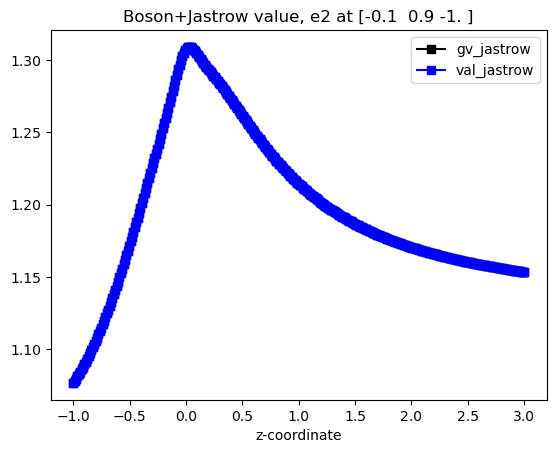

In [92]:
configs = mc.fixed_initial_guess(mol, nconfig)
e=0
sign, val = wf.recompute(configs)
s1, v1 = wf.wf_factors[0].recompute(configs)
s2, v2 = wf.wf_factors[1].recompute(configs)
val3 = v1*v2
epos = configs.electron(e)
grad_vals = [wfi.gradient_value(e, epos, configs) for wfi in wf.wf_factors]
grads, saved_values = list(zip(*grad_vals))
phi0 = saved_values[0]['sign']*saved_values[0]['psi'] #sign0*psi0
phi1 = saved_values[1]['sign']*saved_values[1]['psi']

plt.figure()
# plt.plot(x,phi0, '-sk', label='recompute')
# plt.plot(x,v1, '-sb', label='from_grad')

plt.plot(x,phi1, '-sk', label='gv_jastrow')
plt.plot(x,v2, '-sb', label='val_jastrow')

# plt.plot(x,val3, '-sr', label='recomp2')
# plt.plot(x,psi1, '-sr', label='from_val')
plt.legend()
plt.xlabel('z-coordinate')
plt.title('Boson+Jastrow value, e2 at {}'.format(e2pos) )


Text(0.5, 1.0, 'Boson+Jastrow gradient, e2 at [-0.1  0.9 -1. ]')

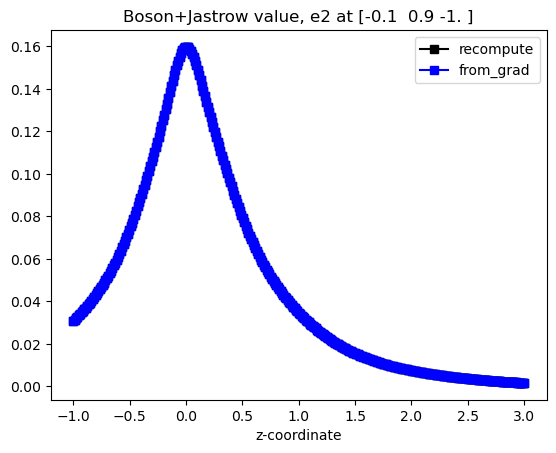

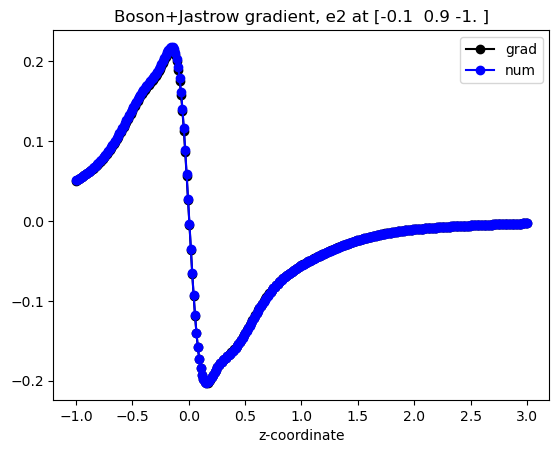

In [86]:
configs = mc.fixed_initial_guess(mol, nconfig)
e=0
sign, val = wf.recompute(configs)



g1, saved = wf.gradient_value(e, configs.electron(e))

val2 = saved['psi']
_, psi1 = wf.value()

y1 = np.gradient(val2)
y2 = g1
dx = configs.configs[1]-configs.configs[0]
dx = dx[dx!=0][0]
# print(dx)

x = configs.configs[:,0][:,2]
h1 = (0,0, 0.0)
h2 = (2.0, 0.0)
e2pos = np.array2string(configs.configs[:,1][0])




plt.figure()
plt.plot(x,val, '-sk', label='recompute')
plt.plot(x,val2, '-sb', label='from_grad')
# plt.plot(x,val3, '-sr', label='recomp2')
# plt.plot(x,psi1, '-sr', label='from_val')
plt.legend()
plt.xlabel('z-coordinate')
plt.title('Boson+Jastrow value, e2 at {}'.format(e2pos) )

plt.figure()
plt.plot(x,g1[2], '-ok', label='grad')
plt.plot(x,y1/dx, '-ob', label='num')
plt.xlabel('z-coordinate')
plt.legend()
plt.title('Boson+Jastrow gradient, e2 at {}'.format(e2pos))


